In [3]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *
import porepy as pp

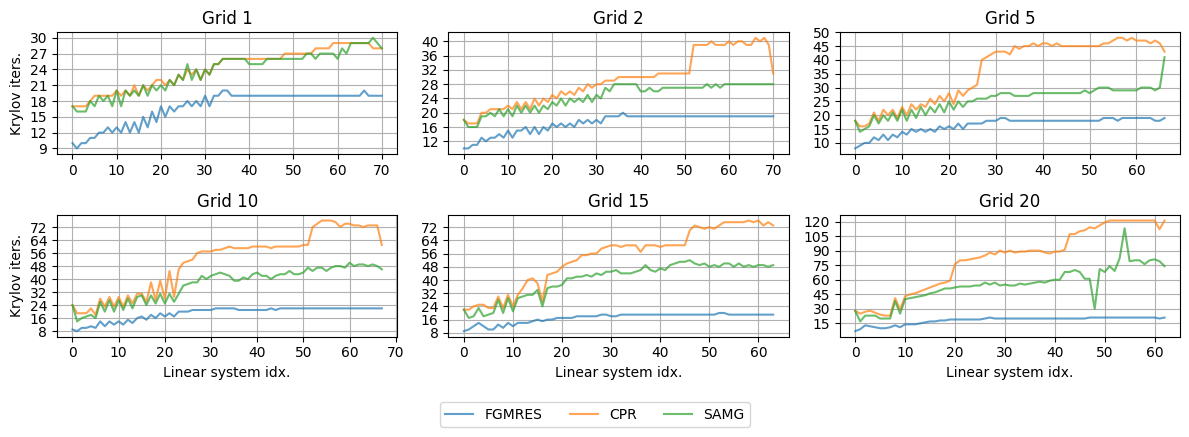

In [4]:
grids = [
    1,
    2,
    5,
    10,
    15,
    20,
]

data = {}
names = {}
solvers = [
    "FGMRES",
    "CPR",
    "SAMG",
]
colors = {name: f"C{i}" for i, name in enumerate(solvers)}


data = {}
names = {}
for i, g in enumerate(grids):
    data[i] = {}
    names[i] = f"Grid {g}"
    for s in solvers:
        try:
            data[i][s] = load_data(f"../stats/stats_thermal_geo5x{g}_sol{s}.json")
        except:
            continue


shape = [2, 3]
figsize = (12, 4)


def render_element(i, data):
    if len(data) == 0:
        return
    for solver_name, d in data.items():
        # color_converged_reason(d, legend=True)
        plt.plot(get_gmres_iterations(d), label=solver_name, alpha=0.7, c=colors[solver_name])
        # plt.twinx()
        # plt.yscale('log')
        # DAY = 3600 * 24
        # ls = get_ls_indices(d)
        # plt.plot(np.array(get_time_steps(d))[ls] / DAY , color='black', alpha=0.5, label='Time')
    plt.gca().grid(True)
    set_integer_ticks("vertical")
    # color_time_steps(data['CPR'], fill=True, legend=True)
    # plt.yscale('log')


plot_grid(
    data, render_element, shape=shape, figsize=figsize, legend=True, ax_titles=names
)

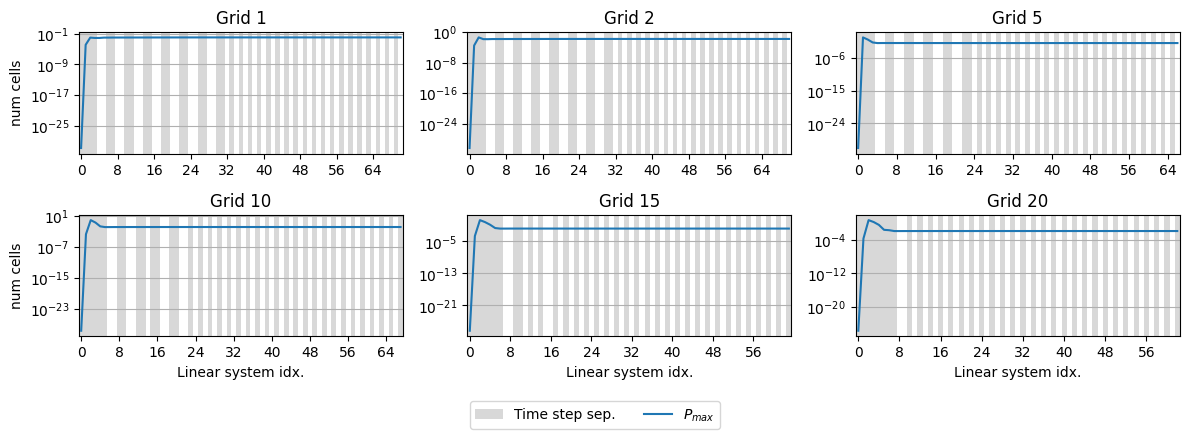

In [5]:
def render_element(i: int, entry: Sequence[TimeStepStats]):
    entry = entry.get('CPR')
    if entry is None:
        return
    st, sl, op = get_num_sticking_sliding_open(entry)
    color_time_steps(entry, fill=True, grid=False, legend=True)
    plt.gca().grid(False)
    plt.gca().grid(True, which="major", axis="y")
    marker = None
    # plt.plot(st, label="Sticking", marker=marker, color=COLOR_STICKING)
    # plt.plot(sl, label="Sliding", marker=marker, color=COLOR_SLIDING)
    # plt.plot(op, label="Open", marker=marker, color=COLOR_OPEN)
    # plt.plot(tr, label="Transition", marker=".", color=COLOR_TRANSITION)

    cfl = get_cfl(entry)
    # peclet_max = get_peclet_max(entry)
    peclet_mean = get_peclet_mean(entry)
    diffusion = get_fourier_max(entry)
    convection = get_enthalpy_max(entry)
    # plt.twinx()
    # plt.plot(cfl, label='CFL')
    plt.plot(convection, label=r'$P_{max}$')
    plt.yscale('log')

plot_grid(
    data,
    render_element,
    shape=shape,
    figsize=figsize,
    ylabel="num cells",
    ax_titles=names,
    #   ylabel="Fract. len., m"
)
# plt.savefig(save_path + 'fracture_length.pdf', bbox_inches='tight')

In [6]:
from collections import defaultdict
import pandas as pd

table = dict()

NDIGITS = 1

for g in grids:
    table[g] = {}
    for s in solvers:
        stats_name = f"stats_thermal_geo5x{g}_sol{s}.json"
        try:
            entry = load_data(f"../stats/{stats_name}")
            dofs_info = load_data(f"../stats/dofs_info_{stats_name}")
        except FileNotFoundError:
            continue
        total_dofs = dofs_info["total dofs"]
        table[g]["Total DoFs"] = f'{total_dofs:.0e}'
        table[g][s] = round(np.mean(get_gmres_iterations(entry)), NDIGITS)

        # if g in [1, 2, 5]:
        #     direct = load_data(f"../stats/stats_geo0x{g}_sol{21}_ph{1}_bb{2}_fr{1}.json")
        #     table["GMRES dir."].append(round(np.mean(get_gmres_iterations(direct)), NDIGITS))
        # else:
        #     table["GMRES dir."].append('-')

        # table['Newton iters.'].append(round(np.mean(get_newton_iterations(entry)), NDIGITS))
        converged_reason = get_petsc_converged_reason(entry)
        # table['\# lim iters.'].append(sum(np.array(get_petsc_converged_reason(entry)) < 0))

table = pd.DataFrame(table)
table.rename(columns=table.iloc[0], inplace=True)
table = table[1:]
table.columns.name = 'Total DoFs'
table

Total DoFs,3e+03,7e+03,3e+04,1e+05,4e+05,1e+06
FGMRES,16.8,17.1,16.4,18.9,17.0,18.1
CPR,24.1,29.3,36.3,51.0,54.0,81.2
SAMG,23.6,24.5,25.5,36.8,40.2,54.7


In [7]:
print(table.to_latex(float_format=f'%.{NDIGITS}f'))

\begin{tabular}{lllllll}
\toprule
Total DoFs & 3e+03 & 7e+03 & 3e+04 & 1e+05 & 4e+05 & 1e+06 \\
\midrule
FGMRES & 16.8 & 17.1 & 16.4 & 18.9 & 17.0 & 18.1 \\
CPR & 24.1 & 29.3 & 36.3 & 51.0 & 54.0 & 81.2 \\
SAMG & 23.6 & 24.5 & 25.5 & 36.8 & 40.2 & 54.7 \\
\bottomrule
\end{tabular}



In [3]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *
from thermal_runscript_5 import make_model
import porepy as pp

model = make_model(
    {
        "geometry": 5,
        "grid_refinement": 1,
        "solver": 3,
        'steady_state': True,
    }
)
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model.assemble_linear_system()
rhs = model.linear_system[1]



Sim time: 0.00e+00, Dt: 1.00e+00 (days)
Temperature: 393.00, 393.00
Peclet: 0.0e+00, CFL: 2.9e-16
sticking: 131, sliding: 0, open: 0


In [ ]:
# mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(
#     load_data(f"../stats/{model.simulation_name()}.json"), 9
# )

# mat = scipy.sparse.load_npz('../matrices/stats_thermal_geo5x10_sol3_1739045561550.npz')
# rhs = np.load('../matrices/stats_thermal_geo5x10_sol3_1739045561550_rhs.npy')
# iterate = np.load('../matrices/stats_thermal_geo5x10_sol3_1739045561550_iterate.npy')
# state = np.load('../matrices/stats_thermal_geo5x10_sol3_1739045561550_state.npy')
# dt = 4e-3

KeyboardInterrupt: 

In [ ]:
# model.linear_system = mat, rhs
# model.bmat.mat = mat
# model.equation_system.set_variable_values(state, time_step_index=0)
# model.equation_system.set_variable_values(iterate, iterate_index=0)
# model.ad_time_step.set_value(dt)
# model.time_manager.dt = dt

(5643, 5643)

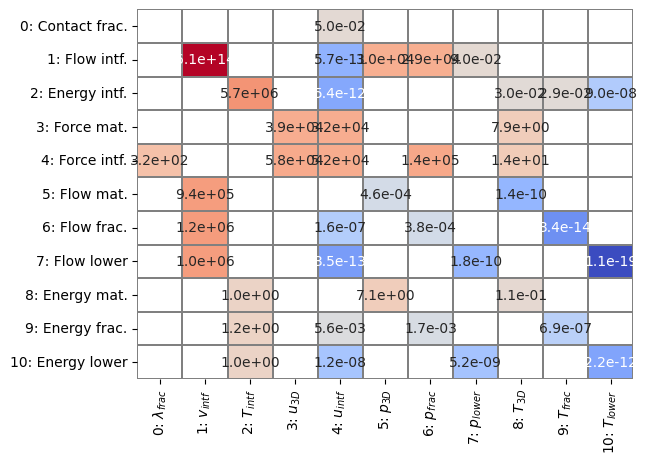

In [4]:
J = model.bmat[:]
J.plot_max()
J.shape

/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Construction took: 1.29
  0 KSP Residual norm 8.096395039285e+03 
  1 KSP Residual norm 7.289891309044e+03 
  2 KSP Residual norm 6.769257862634e+03 
  3 KSP Residual norm 8.871477248764e+02 
  4 KSP Residual norm 2.198004617423e+02 
  5 KSP Residual norm 5.586733741038e+01 
  6 KSP Residual norm 1.321359792693e+01 
  7 KSP Residual norm 3.170034532237e+00 
  8 KSP Residual norm 2.031911107538e+00 
  9 KSP Residual norm 1.369632046752e+00 
 10 KSP Residual norm 9.615974698222e-01 
 11 KSP Residual norm 3.088815024747e-01 
 12 KSP Residual norm 6.279470520991e-02 
 13 KSP Residual norm 2.220764402105e-02 
 14 KSP Residual norm 1.333852015351e-02 
 15 KSP Residual norm 8.804581495155e-03 
 16 KSP Residual norm 1.924860161164e-03 
 17 KSP Residual norm 9.949113521513e-04 
 18 KSP Residual norm 5.281673551087e-04 
 19 KSP Residual norm 2.003370385555e-04 
 20 KSP Residual norm 5.575641941067e-05 
 21 KSP Residual norm 9.609990889775e-06 
 22 KSP Residual norm 1.934387168812e-06 
 23 KSP Re

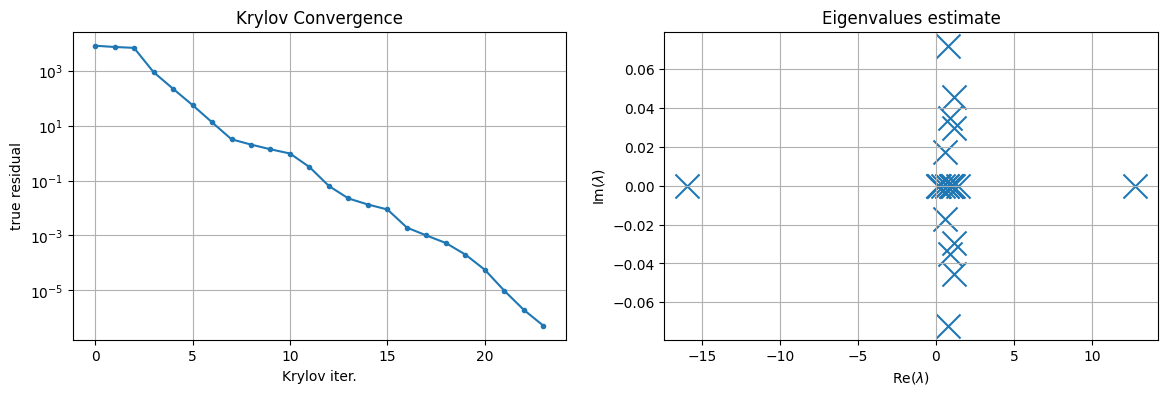

In [6]:
from fixed_stress import make_fs_analytical, make_fs_analytical_slow_new
from hm_solver import build_mechanics_near_null_space
from mat_utils import *
from block_matrix import *
from full_petsc_solver import *

contact = [0]
intf = [1, 2]
mech = [3, 4]
flow = [5, 6, 7]
temp = [8, 9, 10]
scheme = LinearTransformedScheme(
    right_transformations=[lambda bmat: model.Qright(contact_group=0, u_intf_group=4)],
    inner=PetscKSPScheme(
        petsc_options={
            # "ksp_type": "fgmres",
            "ksp_monitor": None,
        },
        compute_eigenvalues=True,
        preconditioner=PetscFieldSplitScheme(
            groups=contact,
            block_size=model.nd,
            fieldsplit_options={
                "pc_fieldsplit_schur_precondition": "selfp",
            },
            elim_options={
                "pc_type": "pbjacobi",
            },
            keep_options={
                "mat_schur_complement_ainv_type": "blockdiag",
            },
            complement=PetscFieldSplitScheme(
                groups=intf,
                elim_options={
                    "pc_type": "ilu",
                },
                fieldsplit_options={
                    "pc_fieldsplit_schur_precondition": "selfp",
                },
                complement=PetscFieldSplitScheme(
                    groups=mech,
                    elim_options=(
                        {
                            "pc_type": "hypre",
                            "pc_hypre_type": "boomeramg",
                            "pc_hypre_boomeramg_strong_threshold": 0.7,
                            "pc_hypre_boomeramg_smooth_type": "Euclid",
                        }
                    ),
                    keep_options={
                    },
                    block_size=model.nd,
                    invert=lambda bmat: csr_to_petsc(
                        make_fs_analytical_slow_new(
                            model,
                            bmat,
                            p_mat_group=5,
                            p_frac_group=6,
                            groups=flow + temp,
                        ).mat,
                        bsize=1,
                    ),
                    complement=PetscCPRScheme(
                        groups=flow + temp,
                        pressure_groups=flow,
                        pressure_options={
                            "pc_type": "hypre",
                            "pc_hypre_type": "boomeramg",
                            "pc_hypre_boomeramg_strong_threshold": 0.7,
                            "pc_hypre_boomeramg_smooth_type": "Euclid",
                        },
                        others_options={
                            "pc_type": "hypre",
                            "pc_hypre_type": "boomeramg",
                            "pc_hypre_boomeramg_strong_threshold": 0.7,
                        },
                        cpr_options={
                            "pc_composite_pcs": "fieldsplit,ksp",
                            "sub_1_ksp_ksp_type": "preonly",
                            "sub_1_ksp_pc_type": "hypre",
                            "sub_1_ksp_pc_hypre_type": "Euclid",
                        },
                    ),
                ),
            ),
        ),
    ),
)

solve_petsc_3(
    J,
    rhs_global=rhs,
    ksp_scheme=scheme,
    ksp_view=True,
)

/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Construction took: 0.68
  0 KSP Residual norm 8.096395039285e+03 
  1 KSP Residual norm 7.987093821822e+03 
  2 KSP Residual norm 4.814146011089e+03 
  3 KSP Residual norm 5.309666474574e+02 
  4 KSP Residual norm 4.861923589642e+02 
  5 KSP Residual norm 4.173699042719e+02 
  6 KSP Residual norm 3.146102946545e+02 
  7 KSP Residual norm 2.965817199871e+02 
  8 KSP Residual norm 1.775310323225e+02 
  9 KSP Residual norm 7.002066139503e+01 
 10 KSP Residual norm 1.785484035402e+01 
 11 KSP Residual norm 1.338464207790e+01 
 12 KSP Residual norm 3.546585972063e+00 
 13 KSP Residual norm 3.992090993257e-01 
 14 KSP Residual norm 7.363208406420e-02 
 15 KSP Residual norm 5.649517492952e-02 
 16 KSP Residual norm 2.965387586552e-02 
 17 KSP Residual norm 4.145782163695e-03 
 18 KSP Residual norm 3.489363167989e-04 
 19 KSP Residual norm 2.161507175775e-05 
 20 KSP Residual norm 1.264422595611e-06 
 21 KSP Residual norm 9.969536916078e-08 
 22 KSP Residual norm 6.246525962680e-09 
Solve  too

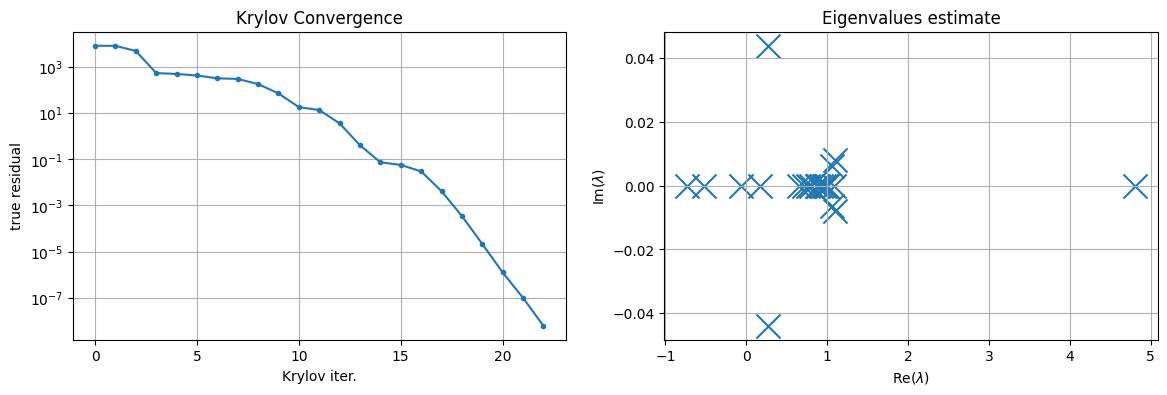

In [33]:
from thermal.thm_solver import make_pt_permutation


scheme = LinearTransformedScheme(
    right_transformations=[lambda bmat: model.Qright(contact_group=0, u_intf_group=4)],
    left_transformations=[
        lambda bmat: model.scale_energy_balance(bmat),
    ],
    inner=PetscKSPScheme(
        petsc_options={
            # "ksp_type": "fgmres",
            "ksp_monitor": None,
            "ksp_rtol": 1e-12,
        },
        compute_eigenvalues=True,
        preconditioner=PetscFieldSplitScheme(
            groups=contact,
            block_size=model.nd,
            fieldsplit_options={
                "pc_fieldsplit_schur_precondition": "selfp",
            },
            elim_options={
                "pc_type": "pbjacobi",
            },
            keep_options={
                "mat_schur_complement_ainv_type": "blockdiag",
            },
            complement=PetscFieldSplitScheme(
                groups=intf,
                elim_options={
                    "pc_type": "ilu",
                },
                fieldsplit_options={
                    "pc_fieldsplit_schur_precondition": "selfp",
                },
                complement=PetscFieldSplitScheme(
                    groups=mech,
                    elim_options=(
                        {
                            # 'pc_type': 'gamg',
                            # "pc_type": "hypre",
                            # "pc_hypre_type": "boomeramg",
                            # "pc_hypre_boomeramg_strong_threshold": 0.7,
                            # 'pc_hypre_boomeramg_max_row_sum': 1.0,
                            # "pc_hypre_boomeramg_smooth_type": "Euclid",
                            "pc_type": "hmg",
                            "hmg_inner_pc_type": "hypre",
                            # "hmg_inner_pc_hypre_type": "boomeramg",
                            # 'hmg_inner_pc_type': 'gamg',
                            # 'hmg_inner_pc_gamg_threshold': 0.1,
                            "hmg_inner_pc_hypre_boomeramg_strong_threshold": 0.75,
                            "mg_levels_ksp_type": "richardson",
                            "mg_levels_ksp_max_it": 2,
                            'mg_levels_pc_type': 'ilu',
                        }
                    ),
                    keep_options={},
                    block_size=model.nd,
                    invert=lambda bmat: csr_to_petsc(
                        make_fs_analytical_slow_new(
                            model,
                            bmat,
                            p_mat_group=5,
                            p_frac_group=6,
                            groups=flow + temp,
                        ).mat,
                        bsize=1,
                    ),
                    complement=PetscCompositeScheme(
                        groups=flow + temp,
                        solvers=[
                            PetscFieldSplitScheme(
                                groups=flow,
                                fieldsplit_options={
                                    "pc_fieldsplit_type": "additive",
                                },
                                elim_options={
                                    "pc_type": "hypre",
                                    "pc_hypre_type": "boomeramg",
                                    "pc_hypre_boomeramg_strong_threshold": 0.7,
                                },
                                complement=PetscFieldSplitScheme(
                                    groups=temp,
                                    elim_options={
                                        "pc_type": "none",
                                    },
                                ),
                            ),
                            PetscFieldSplitScheme(
                                groups=flow + temp,
                                python_pc=lambda bmat: PcPythonPermutation(
                                    make_pt_permutation(
                                        bmat, p_groups=flow, t_groups=temp
                                    ),
                                    block_size=2,
                                ),
                                elim_options={
                                    # "python_pc_type": "ilu",
                                    "python_pc_type": "hypre",
                                    "python_pc_hypre_type": "Euclid",
                                },
                            ),
                        ],
                    ),
                ),
            ),
        ),
    ),
)
solve_petsc_3(
    J,
    rhs_global=rhs,
    ksp_scheme=scheme,
    ksp_view=True,
)